In [2]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

tf.enable_eager_execution()

In [21]:
class DQN:
    def __init__(self,
                 env_name,
                 replay_buffer_size = 100000,
                 min_replay_size = 100,
                 episodes = 1000,
                 batch_size = 64,
                 gamma = 1.,
                 target_update_period = 10,
                 final_running_av_reward = 150.0,
                 eps_min = 0.01,
                 eps_decay = 0.995):
    
        self.env = gym.make(env_name)
    
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.copy_weights()
        
        self.buffer = deque(maxlen = replay_buffer_size)
        self.eps = 1.
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.min_replay_size = min_replay_size
        self.episodes = episodes
        self.batch_size = batch_size
        self.gamma = gamma
        self.target_update_period = target_update_period
        self.final_running_av_reward = final_running_av_reward
    
    def create_model(self):
        model = Sequential()
        model.add(Dense(16, input_dim=len(self.env.observation_space.sample()), activation='tanh'))
        model.add(Dense(32, activation='tanh'))
        model.add(Dense(self.env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=0.01, decay=0.01))
        return model
    
    def copy_weights(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def train(self):
        episode_rewards = []
        max_q_values = []
        
        try:
            for i_episode in range(self.episodes):
                state = self.env.reset()
                total_reward = 0.
                total_max_q = 0.
                time_steps = 0
                done = False
                while not done:
                    # self.env.render()
                    acts_qs = self.model(np.atleast_2d(state)).numpy()[0]
                    max_q = max(acts_qs)
                    if np.random.random() <= self.eps:
                        action = self.env.action_space.sample()
                    else:
                        action = np.argmax(acts_qs)

                    next_state, reward, done, info = self.env.step(action)
                    self.buffer.append((state, action, reward, next_state , done))
                    state=next_state

                    total_reward += reward
                    total_max_q += max_q
                    time_steps += 1

                if len(self.buffer) >= self.min_replay_size:
                    batch = random.sample(self.buffer, min(self.batch_size, len(self.buffer)))
                    target_qs = []
                    states = []
                    for (s, a, r, next_s, is_terminal) in batch:
                        states.append(s)
                        target_predict = self.model(np.atleast_2d(s)).numpy()[0]
                        target_predict[a] = r if is_terminal \
                            else r + self.gamma * np.max(self.target_model(np.atleast_2d(next_s))[0])
                        target_qs.append(target_predict)
                    self.model.fit(np.array(states), np.array(target_qs), batch_size=len(states), verbose=0)

                if self.eps > self.eps_min:
                    self.eps *= self.eps_decay

                if i_episode % self.target_update_period == 0:
                    self.copy_weights()

                episode_rewards.append(total_reward)
                max_q_values.append(total_max_q / time_steps)

                running_av_reward = np.array(episode_rewards[max(0, i_episode-100):(i_episode+1)]).mean()
                if i_episode % 100 == 0:
                    print("episode:", i_episode, "; average reward for last 100 episodes:", running_av_reward, sep='')
                if (i_episode+1) >= 100 and running_av_reward >= self.final_running_av_reward:
                    print("Solved with ", i_episode, " episodes; total reward:", 
                          total_reward, "\naverage reward for last 100 episodes:", running_av_reward, sep='')
                    break
        finally:
            self.env.close()
        return episode_rewards, max_q_values
    
    def test(self, eps=0.02):
        state = self.env.reset()
        done = False
        while not done:
            if random.random() <= eps:
                action = self.env.action_space.sample()
            else:
                action = np.argmax(self.model(np.atleast_2d(state)).numpy()[0])
            env.render()
            state, reward, done, info = self.env.step(action)
        self.env.close()

In [22]:
agents_num = 9
agents = []
total_rewards = []
max_q_values = []
for i in range(agents_num):
    print("Agent №", i+1, sep='')
    agent = DQN('CartPole-v0')
    rewards, q_values = agent.train()
    total_rewards.append(rewards)
    max_q_values.append(q_values)
    agents.append(agent)
    print("-----------------------------------------------------")

Agent №1
episode:0; average reward for last 100 episodes:9.0
episode:100; average reward for last 100 episodes:20.178217821782177
episode:200; average reward for last 100 episodes:24.821782178217823
episode:300; average reward for last 100 episodes:78.34653465346534
episode:400; average reward for last 100 episodes:85.98019801980197
episode:500; average reward for last 100 episodes:91.87128712871286
episode:600; average reward for last 100 episodes:129.17821782178217
Solved with 678 episodes; total reward:160.0
average reward for last 100 episodes:150.36633663366337
-----------------------------------------------------
Agent №2
episode:0; average reward for last 100 episodes:11.0
episode:100; average reward for last 100 episodes:33.306930693069305
episode:200; average reward for last 100 episodes:59.92079207920792
episode:300; average reward for last 100 episodes:96.58415841584159
episode:400; average reward for last 100 episodes:118.20792079207921
episode:500; average reward for last 

In [7]:
def make_plots(rewards, q_values): 
    max_episodes = len(min(rewards, key=len))
    cutted_rewards = [np.array(r[:max_episodes]) for r in rewards]
    rewards_means = np.array(cutted_rewards).mean(axis=0)
    
    plt.title("Average episode total rewards for 9 agents")
    plt.xlabel("episode")
    plt.ylabel("reward")
    plt.plot(rewards_means)
    plt.show()
    
    cutted_q_values = [np.array(q[:max_episodes]) for q in q_values]
    q_value_means = np.array(cutted_q_values).mean(axis=0)
    plt.title("Max Q-value for 9 agents")
    plt.xlabel("episode")
    plt.ylabel("q-value")
    plt.plot(q_value_means)
    plt.show()

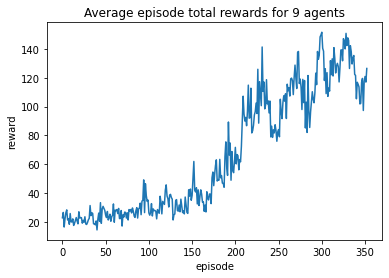

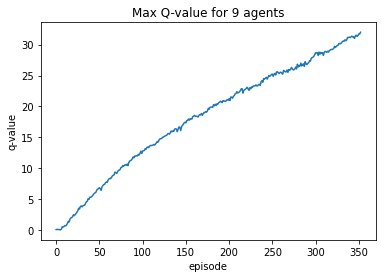

In [23]:
make_plots(total_rewards, max_q_values)